# Optimization Model - Bus Charging Scheduling | Sensitivity Analysis

## Initialization

In [31]:
import pyomo.environ as pyo
from pyomo.solvers.plugins.solvers.cplex_persistent import CPLEXPersistent
from pyomo.opt import SolverFactory
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

In [32]:
data = pd.read_excel('Instances/input_small.xlsx', None)
EXEC_PATH = '/Applications/CPLEX_Studio221/cplex/bin/x86-64_osx/cplex'

## Model definition

In [33]:
def createModel(data, C_bat = data['Buses']['Bus (kWh)'].tolist(), k= len(data['Buses']['Bus (kWh)']), alpha = data['Chargers']['Charger (kWh/min)'].tolist(),
n = len(data['Chargers']['Charger (kWh/min)']),R = 130):

    model = pyo.ConcreteModel() # create model
    
    # data
    i = len(data['Trip time']['Time begin (min)'])
    t = len(data['Energy price']['Energy buying price (per minute)'])
    l = len(data['Power price']['Power'])
    T_start = data['Trip time']['Time begin (min)'].tolist()
    T_start = [int(x) for x in T_start]
    T_end = data['Trip time']['Time finish (min)'].tolist()
    T_end = [int(x) for x in T_end]
    ch_eff = 0.90
    dch_eff = 1/0.9
    gama = data['Energy consumption']['Uncertain energy (kWh/km*min)'].tolist()
    P = data['Energy price']['Energy buying price (per minute)'].tolist()
    S = data['Energy price']['Energy selling price (per minute)'].tolist()
    E_0 = 0.2
    E_min = 0.2
    E_max = 1
    E_end = 0.2
    U_pow = data['Power price']['Power'].tolist()
    U_price = data['Power price']['Price'].tolist()
    U_max = data['Chargers']['Max Power (kW)'].tolist()
    Ah = 905452
    V = 512
    T = t

    # sets
    model.I = pyo.RangeSet(i) # set of trips
    model.T = pyo.RangeSet(t) # set of timesteps
    model.K = pyo.RangeSet(k) # set of buses
    model.N = pyo.RangeSet(n) # set of chargers
    model.L = pyo.RangeSet(l) # set of peak power levels

    # parameters
    model.T_start = pyo.Param(model.I, initialize=lambda model, i: T_start[i-1]) # start time of trip i
    model.T_end = pyo.Param(model.I, initialize=lambda model, i: T_end[i-1]) # end time of trip i
    model.alpha = pyo.Param(model.N, initialize=lambda model, n: alpha[n-1]) # charging power of charger n
    model.beta = pyo.Param(model.N, initialize=lambda model, n: alpha[n-1]) # discharging power of charger n
    model.ch_eff = pyo.Param(initialize=ch_eff) # charging efficiency of charger n
    model.dch_eff = pyo.Param(initialize=dch_eff) # discharging efficiency of charger n
    model.P = pyo.Param(model.T, initialize=lambda model, t: P[t-1]) # electricity purchasing price in time t
    model.S = pyo.Param(model.T, initialize=lambda model, t: S[t-1]) # electricity selling price in time t
    model.gama = pyo.Param(model.I, initialize=lambda model, i: gama[i-1],mutable=True) # energy consumption
    model.E_0 = pyo.Param(initialize=E_0) # initial energy level of bus k
    model.E_min = pyo.Param(initialize=E_min) # minimum energy level allowed for bus k
    model.E_max = pyo.Param(initialize=E_max) # maximum energy level allowed for bus k
    model.E_end = pyo.Param(initialize=E_end) # minimum energy after an operation day for bus k
    model.C_bat = pyo.Param(model.K, initialize=lambda model, k: C_bat[k-1],mutable=True) # total capacity of the bus k battery
    model.U_pow = pyo.Param(model.L, initialize=lambda model, l: U_pow[l-1]) # power level l
    model.U_price = pyo.Param(model.L, initialize=lambda model, l: U_price[l-1]) # purchasing price for power level l
    model.U_max = pyo.Param(initialize=U_max[0]) # contracted power
    model.R = pyo.Param(initialize=R) # battery replacement costs of the bus k
    model.Ah = pyo.Param(initialize=Ah) # energy consumed until EOL of bus k
    model.V = pyo.Param(initialize=V) # operational voltage of charger n

    # binary variables
    model.b = pyo.Var(model.K,model.I, model.T, within=pyo.Binary) # binary variable indicating if bus k is serving trip i at time t
    model.x = pyo.Var(model.K, model.N, model.T, domain=pyo.Binary) # binary variable indicating if bus k is occupying a charger n at time t to charge
    model.y = pyo.Var(model.K, model.N, model.T, domain=pyo.Binary) # binary variable indicating if bus k is occupying a charger n at time t to discharge
    model.c = pyo.Var(model.K, model.T, domain=pyo.Binary)  # binary variable indicating if bus k is charging/discharging at time t
    model.u = pyo.Var(model.L, domain=pyo.Binary)  # binary variable indicating the peak power level l

    # non-negative variables
    model.e = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals) # energy level of bus k at time t
    model.w_buy = pyo.Var(model.T, within=pyo.NonNegativeReals) # electricity purchased from the grid at time t
    model.w_sell = pyo.Var(model.T, within=pyo.NonNegativeReals) # electricity sold to the grid at time t
    model.d = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals) # total degradation cost of the bus k battery at time t

    # constraints
    model.constraints = pyo.ConstraintList()
    #constraint 2
    for k in model.K:
        for t in model.T:
            model.constraints.add(sum(model.b[k,i,t] for i in model.I) + model.c[k,t] <=1)
    #constraint 3
    for i in model.I: 
        for t in range(model.T_start[i],model.T_end[i]):
            model.constraints.add(sum(model.b[k,i,t] for k in model.K) == 1)
    #constraint 4
    for i in model.I:
        for k in model.K:
            for t in range(model.T_start[i],model.T_end[i]-1):
                model.constraints.add(model.b[k,i,t+1] >= model.b[k,i,t])
    #constraint 5
    for n in model.N:
        for t in model.T:
            model.constraints.add(sum(model.x[k,n,t] for k in model.K) + sum(model.y[k,n,t] for k in model.K) <= 1)
    #constraint 6
    for k in model.K:
        for t in model.T:
            model.constraints.add(sum(model.x[k,n,t] for n in model.N) + sum(model.y[k,n,t] for n in model.N) <= model.c[k,t])
    #constraint 7
    for k in model.K:
        for t in range(2,T+1):
            model.constraints.add(model.e[k,t] == model.e[k,t-1] + sum(model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N) - sum(model.gama[i]*model.b[k,i,t] for i in model.I) - sum(model.dch_eff*model.beta[n]*model.y[k,n,t] for n in model.N))
    #constraint 8.1
    for t in model.T:
        model.constraints.add(sum(model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N for k in model.K) == model.w_buy[t])
    #constraint 8.2
    for t in model.T:
            model.constraints.add(sum(model.dch_eff*model.beta[n]*model.y[k,n,t] for n in model.N for k in model.K) == model.w_sell[t])
    #constraint 9
    model.constraints.add(sum(model.u[l] for l in model.L)==1)
    #constraint 10
    for t in model.T:
        model.constraints.add(sum(model.alpha[n]*model.x[k,n,t] for n in model.N for k in model.K) <= sum(model.U_pow[l]*model.u[l] for l in model.L))  
    #constraint 11
    for t in model.T:
        model.constraints.add(sum(model.alpha[n]*model.x[k,n,t] for n in model.N for k in model.K) + sum(model.beta[n]*model.y[k,n,t] for n in model.N for k in model.K) <= model.U_max)
    #constraint 12
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.e[k,t] >= model.C_bat[k] * model.E_min)
    #constrait 13
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.E_max * model.C_bat[k] >= model.e[k,t] + sum(model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N))          
    #constraint 14.1
    for k in model.K:
        model.constraints.add(model.e[k,1] == model.E_0*model.C_bat[k])
    #constraint 14.2
    for k in model.K:
        model.constraints.add(model.e[k,T]  >= model.E_end*model.C_bat[k])   
    #constraint 15
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.d[k,t] == ((model.R*model.C_bat[1]*1000)/(model.Ah*model.V))* sum(model.beta[n]*model.y[k,n,t] for n in model.N))

    # objective function
    def rule_obj(mod):
        return sum(mod.P[t]*mod.w_buy[t] for t in mod.T) - sum(mod.S[t]*mod.w_sell[t] for t in mod.T) + sum(mod.d[k,t] for k in mod.K for t in mod.T) + sum(mod.U_price[l]*mod.u[l] for l in mod.L)
    model.obj = pyo.Objective(rule=rule_obj, sense=pyo.minimize)

    return model


## Solver

In [34]:
# solving the optimization model
opt = pyo.SolverFactory('cplex_persistent',executable=EXEC_PATH)

## Sensitivity Analysis

In [35]:
def numberBuses(num_bus):
    result = []
    axys_x = []
    for i in range(1,num_bus+1):
        try:
            print("===== number of buses is:",i)
            C_bat = data['Buses']['Bus (kWh)'].tolist()
            C_bat = [C_bat[1]] * i
            model = createModel(data,k=i,C_bat=C_bat)
            #opt.set_instance(model)
            opt.solve(model, tee=False)
            print("objective function is:", model.obj(),'\n')
            result.append(model.obj())
            axys_x.append('Bus(es) = '+str(i))
        except ValueError:
            print('\n-----> Infeasible <-----\n')
    plt.subplots(figsize=(12,6))
    plt.bar(axys_x,result)
    return model, result

def batCapacity(bat_begin,bat_end,step):
    result = []
    axys_x = []
    for bat in range(bat_begin,bat_end+step,step):
        try:
            print("===== battery capacity is:",bat)
            C_bat = [bat] * len(data['Buses']['Bus (kWh)'])
            model = createModel(data,C_bat=C_bat)
            #opt.set_instance(model)
            opt.solve(model, tee=False)
            print("objective function is:", model.obj(),'\n')
            result.append(model.obj())
            axys_x.append(str(bat)+' kWh')
        except ValueError:
            print('\n-----> Infeasible <-----\n')
    plt.subplots(figsize=(12,6))
    plt.bar(axys_x,result)
    return model, result

def numberChargers(num_char):
    result = []
    axys_x = []
    for n in range(1,num_char+1):
        try:
            print("===== number of chargers is:",n)
            alpha = data['Chargers']['Charger (kWh/min)'].tolist()
            alpha = [alpha[1]] * n
            model = createModel(data,n=n,alpha=alpha)
            #opt.set_instance(model)
            opt.solve(model, tee=False)
            print("objective function is:", model.obj(),'\n')
            result.append(model.obj())
            axys_x.append('Charger(s) = '+ str(n))
        except ValueError:
            print('\n-----> Infeasible <-----\n')
    plt.subplots(figsize=(12,6))
    plt.bar(axys_x,result)
    return model, result

def charPower(pow_begin,pow_end,step):
    result = []
    axys_x = []
    for pow in np.arange(pow_begin,pow_end+step,step):
        try:
            print("===== charging power is:",pow)
            alpha = [pow] * len(data['Chargers']['Charger (kWh/min)'])
            model = createModel(data,alpha=alpha)
            #opt.set_instance(model)
            opt.solve(model, tee=False)
            print("objective function is:", model.obj(),'\n')
            result.append(model.obj())
            axys_x.append(str(int(pow*60))+' kW')
        except ValueError:
            print('\n-----> Infeasible <-----\n')
    plt.subplots(figsize=(12,6))
    plt.bar(axys_x,result)
    return model, result

===== number of buses is: 1
ERROR: evaluating object as numeric value: w_buy[1]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object w_buy[1]

-----> Infeasible <-----

===== number of buses is: 2
objective function is: 8.9616 

===== number of buses is: 3
objective function is: 8.961599997847678 

===== number of buses is: 4
objective function is: 8.961599997876789 

===== number of buses is: 5
objective function is: 8.961599998887207 

===== battery capacity is: 235
objective function is: 13.948341772727876 

===== battery capacity is: 260
objective function is: 9.9012 

===== battery capacity is: 285
objective function is: 8.9616 

===== battery capacity is: 310
objective function is: 8.9616 

===== battery capacity is: 335
objective function is: 8.9616 

===== number of chargers is: 1
objective function is: 11.7564 

===== number of chargers is: 2
objective function is: 8.9616 

===== number of chargers is: 3
objective f

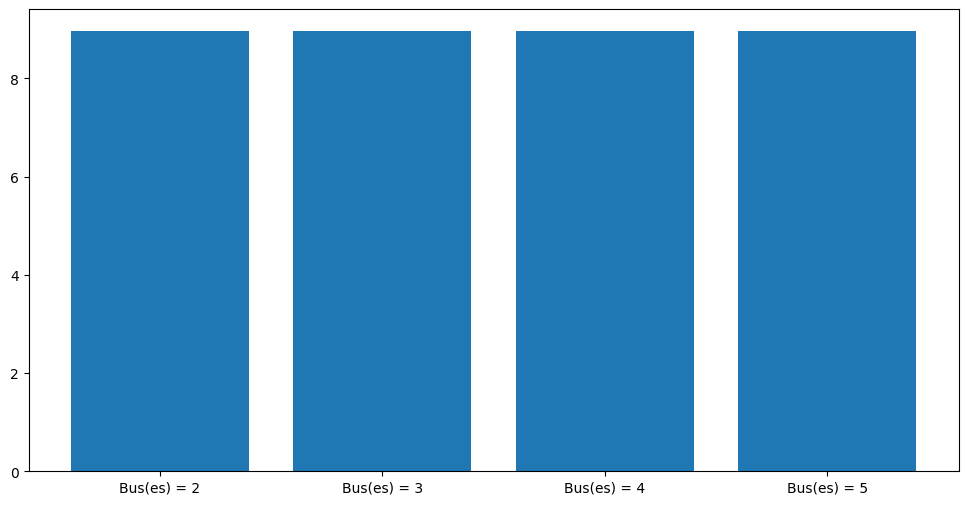

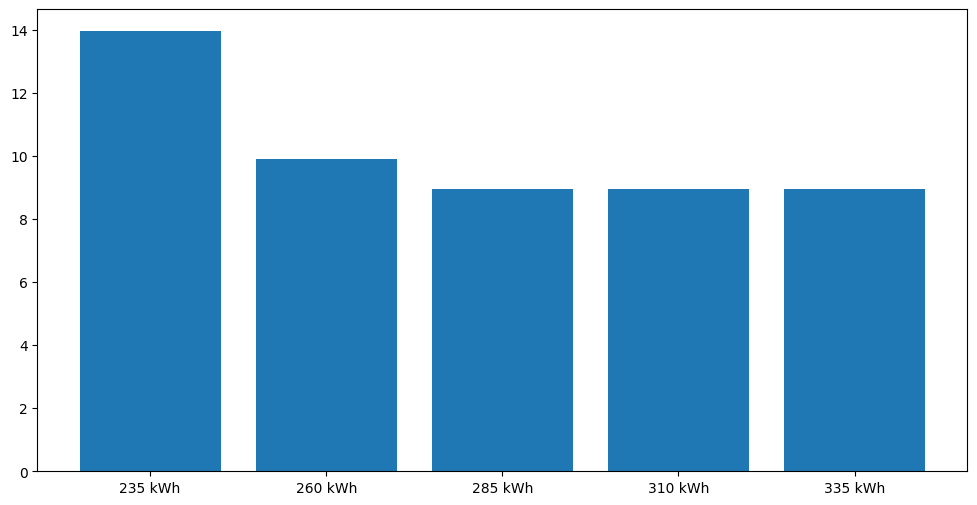

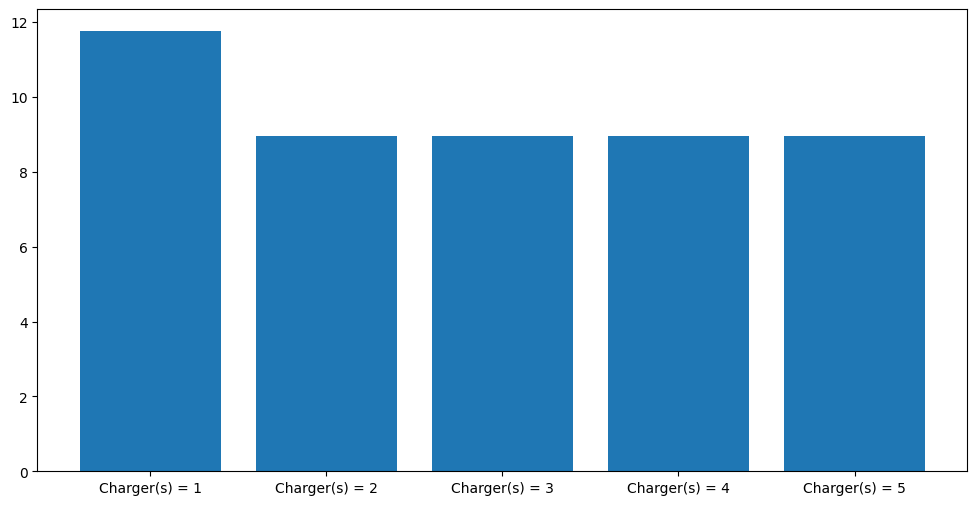

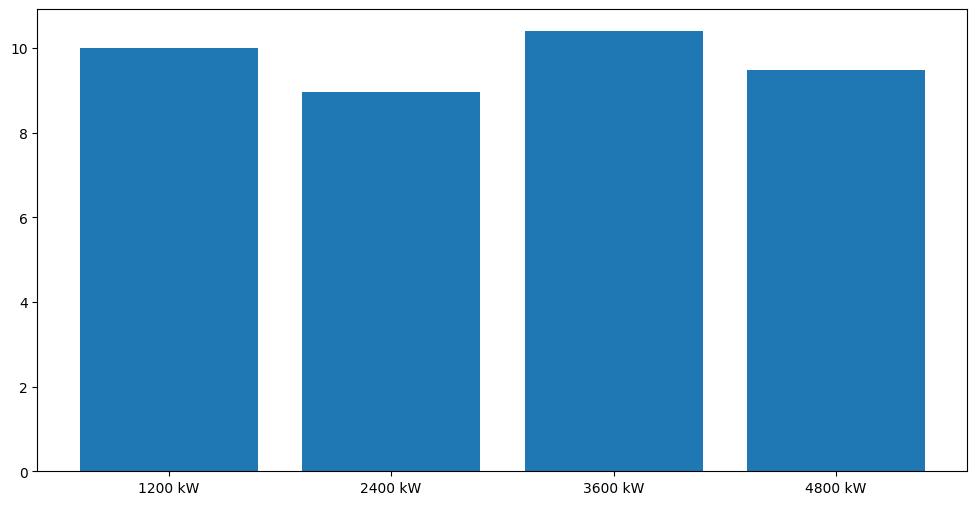

In [36]:
num_bus = 5 # max. number of buses to iterate
battery = [235,335,25] # begin, end, step
num_char = 5 # max. number of chargers to iterate
power = [20,80,20] # begin, end, step

model, result = numberBuses(num_bus)
model, result = batCapacity(battery[0],battery[1],battery[2])
model, result = numberChargers(num_char)
model, result = charPower(power[0],power[1],power[2])

## Visualization

In [37]:
def visualizationData (K,T,e,w,d):
    # retriving energy
    bus_list = []
    energy_list = []
    for k in K:
        bus_number = 'bus' + ' ' + str(k)
        bus_list.append(bus_number)
    for t in T:
        for  k in K:
            energy_list.append(pyo.value(e[k,t]))
    energy_array = np.reshape(energy_list, (len(T), len(bus_list)))
    Energy = pd.DataFrame(energy_array,index=T, columns=bus_list)

    #retriving power
    transac_list = []
    for t in T:
        value = pyo.value(w[t])
        transac_list.append(value)
    W = pd.DataFrame(transac_list, index=model.T, columns=['Power'])

    #retriving degradation
    degradation_list = []
    for k in K:
        for t in T:
            degradation_list.append(pyo.value(d[k,t]))
    degradation = pd.DataFrame(degradation_list)
    return Energy, W, degradation

In [38]:
Energy, Power, Degradation = visualizationData(model.K,model.T,model.e,model.w_sell,model.d)

,bus 1,bus 2
count,47.000000,47.000000
mean,198.544094,148.218981
std,57.135482,48.866306
min,69.600000,69.600000
25%,144.655778,101.908352
50%,202.962700,141.600000
75%,251.028776,200.303375
max,274.962700,213.600000


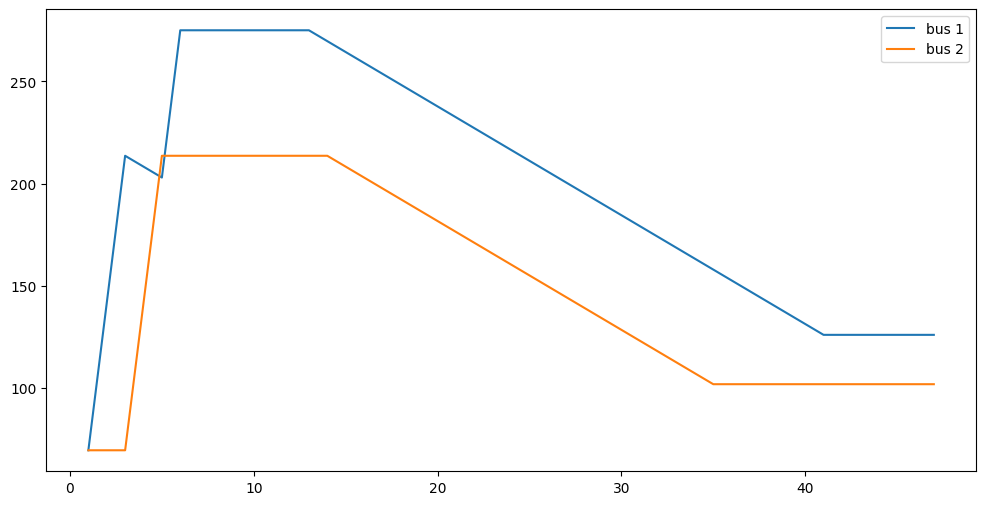

In [39]:
Energy.plot(figsize=(12,6))
Energy.describe()